# Diagrams for cadCAD model structure through cadCAD_diagram

Danilo Lessa Bernardineli

---

This is a mini-demo showcasing the cadCAD_diagram plugin, which allows the user to create visualizations of the structure and flows for any cadCAD model! Just jump to the end so that you see the output of it.

In order to install the plugin, just install through pip by pasing `pip install cadCAD_diagram`. The most typical use-case is to visualize a given cadCAD configuration object through:

```python
from cadCAD_diagram import diagram_from_config
from cadCAD import configs

# Generate visualization for the first config
diagram_from_config(configs[0])
```



## Dependences

In [1]:
%%capture
!pip install cadcad 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

## Definitions

### Initial conditions and parameters

In [3]:
initial_conditions = {
    'prey_population': 100,
    'predator_population': 15
    }

params = {
    "prey_birth_rate": [1.0],
    "predator_birth_rate": [0.01],
    "predator_death_const": [1.0],
    "prey_death_const": [0.03],
    "dt": [0.1] # Precision of the simulation. Lower is more accurate / slower
}

simulation_parameters = {
    'N': 7,
    'T': range(200),
    'M': params
}

### Policies

In [4]:
def p_predator_births(params, step, sL, s):
  dt = params['dt']
  predator_population = s['predator_population']
  prey_population = s['prey_population']
  birth_fraction = params['predator_birth_rate'] + np.random.random() * 0.0002
  births =  birth_fraction * prey_population * predator_population * dt
  return {'add_to_predator_population': births}


def p_prey_births(params, step, sL, s):
  dt = params['dt']
  population = s['prey_population']
  birth_fraction = params['prey_birth_rate'] + np.random.random() * 0.1
  births =  birth_fraction * population * dt
  return {'add_to_prey_population': births}


def p_predator_deaths(params, step, sL, s):
  dt = params['dt']
  population = s['predator_population']
  death_rate = params['predator_death_const'] + np.random.random() * 0.005
  deaths = death_rate * population * dt
  return {'add_to_predator_population': -1.0 * deaths}


def p_prey_deaths(params, step, sL, s):
  dt = params['dt']
  death_rate = params['prey_death_const'] + np.random.random() * 0.1
  prey_population = s['prey_population']
  predator_population = s['predator_population']
  deaths = death_rate * prey_population * predator_population * dt
  return {'add_to_prey_population': -1.0 * deaths}

### State update functions

In [5]:
def s_prey_population(params, step, sL, s, _input):
    y = 'prey_population'
    x = s['prey_population'] + _input['add_to_prey_population']
    return (y, x)


def s_predator_population(params, step, sL, s, _input):
    y = 'predator_population'
    x = s['predator_population'] + _input['add_to_predator_population']
    return (y, x)

### State update blocks

In [6]:

partial_state_update_blocks = [
    { 
        'label': 'Predator dynamics',
        'ignore': False,
        'debug': True,
        'policies': {
            'predator_births': p_predator_births,
            'predator_deaths': p_predator_deaths
        },
        'variables': {
            'predator_population': s_predator_population            
        }
    },
    {
        'label': 'Prey dynamics',
        'ignore': False,
        'policies': {
            'prey_births': p_prey_births,
            'prey_deaths': p_prey_deaths
        },
        'variables': {
            'prey_population': s_prey_population
        }
    }
]

### Configuration and Execution

In [7]:
sim_config = config_sim(simulation_parameters)

exp = Experiment()
exp.append_configs(sim_configs=sim_config, 
                   initial_state=initial_conditions,
                   partial_state_update_blocks=partial_state_update_blocks)


from cadCAD import configs
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.local_mode)
executor = Executor(exec_context=exec_context, configs=configs) 
(records, tensor_field, _) = executor.execute() 


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (200, 5, 7, 2)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 3, 4, 5, 6]
ExpIDs   : [0, 0, 0, 0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 0.67s


### Results

In [8]:
import plotly.express as px

In [9]:
df = pd.DataFrame(records)

fig = px.line(df,
              x=df.prey_population,
              y=df.predator_population,
              color=df.run.astype(str))

fig.show()

## Diagram

In [10]:
%%capture
!pip install cadCAD_diagram==0.0.1.2

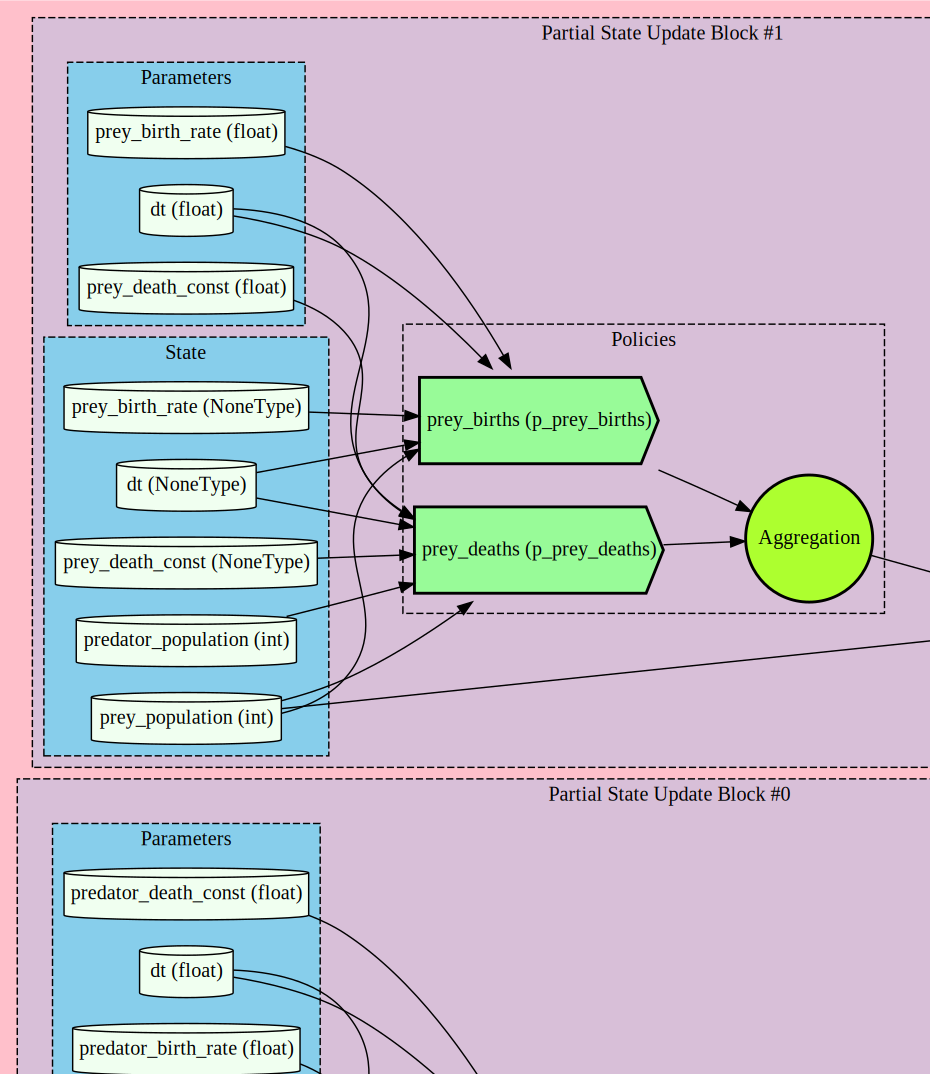

In [11]:
from cadCAD_diagram import diagram_from_config
from cadCAD import configs
diagram_from_config(configs[0])